In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Download Kaggle Dataset

In [2]:
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

# print("Path to dataset files:", path)

# Setup with Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Définir le chemin où se trouve ton fichier ZIP
# Remplace 'brain_tumor_project' par le nom du dossier que tu as créé
ZIP_PATH = '/content/drive/MyDrive/brain-tumor-detection-project/kaggle_3m.zip'

# Définir le répertoire de destination (le dossier temporaire de Colab)
DEST_PATH = '/content/data/'
os.makedirs(DEST_PATH, exist_ok=True)

# Dézipper le fichier (commande Linux exécutée dans Colab)
!unzip -q "{ZIP_PATH}" -d "{DEST_PATH}"
print("✅ Décompression terminée.")

# Définir le nouveau chemin racine des données
DATA_DIR = os.path.join(DEST_PATH, 'kaggle_3m')

# Vérification : Doit imprimer le chemin vers un patient
print(f"Nouveau chemin racine des données : {DATA_DIR}")

✅ Décompression terminée.
Nouveau chemin racine des données : /content/data/kaggle_3m


In [4]:
# 1. Rappel du chemin que tu utilises actuellement
print(f"👉 Ton chemin DATA_DIR actuel est : {DATA_DIR}")

# 2. Vérification d'existence
if not os.path.exists(DATA_DIR):
    print("❌ ERREUR FATALE : Ce dossier n'existe pas ! Le chemin est faux.")
else:
    print("✅ Le dossier racine existe. Regardons ce qu'il y a dedans...")

    # 3. Lister le contenu direct
    contenu = os.listdir(DATA_DIR)
    print(f"📂 Contenu trouvé ({len(contenu)} éléments) :")
    print(contenu[:10]) # On affiche les 10 premiers

    # 4. Vérification du piège classique ("Dossier dans un dossier")
    # Souvent, le dézippage crée un sous-dossier supplémentaire
    if 'kaggle_3m' in contenu:
        print("\n⚠️ ALERTE : Je vois un dossier 'kaggle_3m' À L'INTÉRIEUR de ton dossier.")
        print("💡 SOLUTION : Ton chemin s'arrête trop tôt.")
        print(f"Essaie de changer DATA_DIR en : {os.path.join(DATA_DIR, 'kaggle_3m')}")

👉 Ton chemin DATA_DIR actuel est : /content/data/kaggle_3m
✅ Le dossier racine existe. Regardons ce qu'il y a dedans...
📂 Contenu trouvé (112 éléments) :
['TCGA_HT_A61A_20000127', 'TCGA_FG_5962_20000626', 'TCGA_DU_5872_19950223', 'TCGA_CS_6667_20011105', 'TCGA_DU_A5TP_19970614', 'TCGA_DU_7013_19860523', 'TCGA_DU_8164_19970111', 'TCGA_HT_7693_19950520', 'TCGA_CS_4943_20000902', 'TCGA_DU_7299_19910417']


# Setup in local

In [3]:
# Bien penser à remplacer le chmin vers la source de données
DATA_DIR = '/Users/victor/code/afallo/brain_tumor_detection_project/raw_data/segmentation/kaggle_3m'

# Start Notebook

## To DF + Balancing des classes

In [6]:
def create_diagnosed_dataframe(data_dir):
    data = []

    print("🕵️‍♂️ Analyse et vérification des fichiers en cours...")

    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if 'mask' in filename and filename.endswith('.tif'):

                mask_path = os.path.join(dirname, filename)
                image_filename = filename.replace('_mask', '')
                image_path = os.path.join(dirname, image_filename)

                # 1. Vérification d'intégrité : L'image source existe-t-elle ?
                if os.path.exists(image_path):

                    # 2. Vérification de contenu : Le masque est-il vide ?
                    # On lit le masque en niveau de gris (0 = noir, 255 = blanc)
                    try:
                        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                        # Si la valeur max est > 0, c'est qu'il y a une tumeur (du blanc)
                        has_tumor = 1 if np.max(mask_img) > 0 else 0

                        data.append({
                            'image_path': image_path,
                            'mask_path': mask_path,
                            'has_tumor': has_tumor
                        })
                    except Exception as e:
                        print(f"⚠️ Fichier corrompu ignoré : {filename} ({e})")

    df = pd.DataFrame(data)
    return df

# Exécution
df = create_diagnosed_dataframe(DATA_DIR)

🕵️‍♂️ Analyse et vérification des fichiers en cours...


In [7]:
def balance_dataset(df):
    # 1. On sépare les deux groupes
    df_tumor = df[df['has_tumor'] == 1]
    df_healthy = df[df['has_tumor'] == 0]

    print(f"Original -> Tumeurs: {len(df_tumor)} | Sains: {len(df_healthy)}")

    # 2. On décide combien de sains on garde
    # Pour un U-Net, un ratio 50/50 ou 60/40 est souvent idéal.
    # Ici, on garde autant de sains que de tumeurs (ratio 1:1)
    n_samples = len(df_tumor)

    # Si on a moins de sains que de tumeurs (rare), on prend tout
    if len(df_healthy) > n_samples:
        df_healthy_sampled = df_healthy.sample(n=n_samples, random_state=42)
    else:
        df_healthy_sampled = df_healthy

    # 3. On recombine et on mélange
    df_balanced = pd.concat([df_tumor, df_healthy_sampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced

# --- EXÉCUTION ---
df_final = balance_dataset(df)

print(f"\n✅ Dataset Équilibré Prêt !")
print(f"Taille finale : {len(df_final)} images")
print(f"Répartition : 50% Tumeurs / 50% Sains (environ)")

Original -> Tumeurs: 1373 | Sains: 2556

✅ Dataset Équilibré Prêt !
Taille finale : 2746 images
Répartition : 50% Tumeurs / 50% Sains (environ)


In [8]:
df_final

,image_path,mask_path,has_tumor
0,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
1,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
2,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
3,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
4,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
...,...,...,...
2741,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
2742,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
2743,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
2744,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1


## Viz Mask tumeur & équilibre

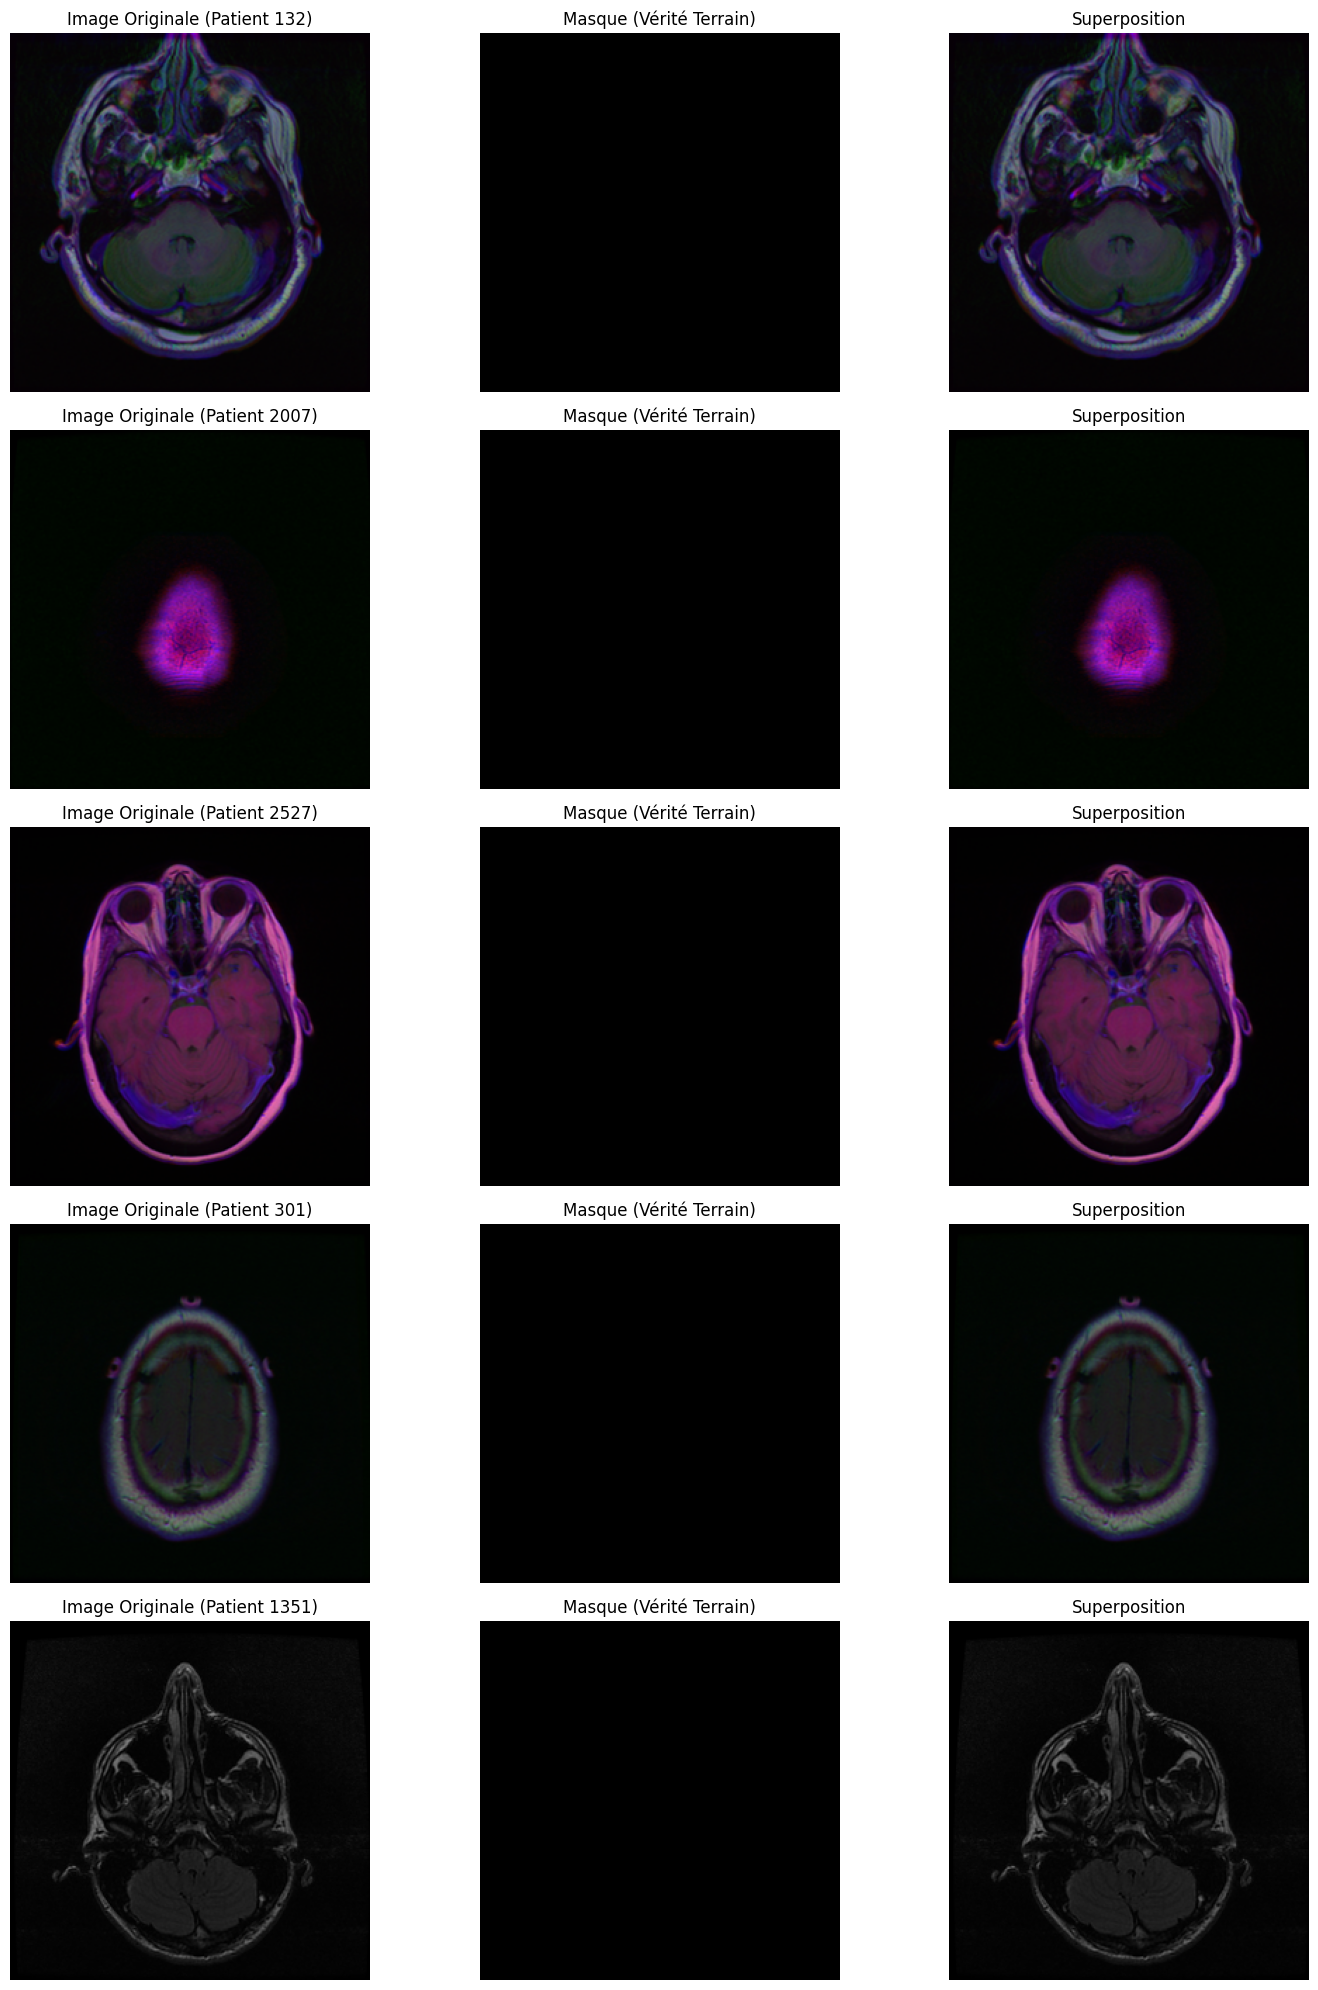

In [10]:
def visualize_data(df, n_samples=5):
    plt.figure(figsize=(15, n_samples * 4))

    # On prend n_samples indices au hasard dans le dataframe
    indices = random.sample(range(len(df)), n_samples)

    for i, idx in enumerate(indices):
        img_path = df.iloc[idx]['image_path']
        mask_path = df.iloc[idx]['mask_path']

        # Lecture des images
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Conversion BGR -> RGB pour l'affichage correct

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # --- Création de la superposition (Overlay) ---
        # On crée une copie de l'image pour dessiner dessus
        overlay = img.copy()

        # On colorie en rouge là où le masque est blanc (tumeur)
        # mask > 0 renvoie les pixels de la tumeur
        overlay[mask > 0] = [255, 0, 0] # Rouge pur

        # On applique la transparence (alpha blending)
        # image_finale = alpha * overlay + (1-alpha) * image_originale
        final_img = cv2.addWeighted(overlay, 0.4, img, 0.6, 0)

        # --- Affichage ---
        # 1. Image Originale
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title(f"Image Originale (Patient {idx})")
        plt.axis('off')

        # 2. Masque
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Masque (Vérité Terrain)")
        plt.axis('off')

        # 3. Superposition
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(final_img)
        plt.title("Superposition")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Lancer la visualisation
visualize_data(df_final)

--- Répartition exacte ---
1    1373
0    1373
Name: has_tumor, dtype: int64

--- En pourcentage ---
1    50.0
0    50.0
Name: has_tumor, dtype: float64


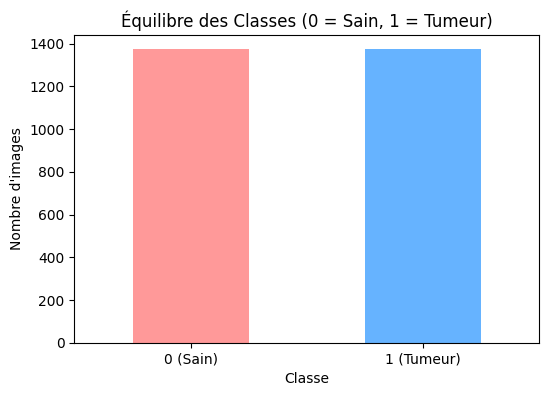

In [11]:
# 1. Compter les valeurs exactes
counts = df_final['has_tumor'].value_counts()

print("--- Répartition exacte ---")
print(counts)

# 2. Vérifier les pourcentages
percentages = df_final['has_tumor'].value_counts(normalize=True) * 100
print("\n--- En pourcentage ---")
print(percentages)

# 3. Visualisation graphique
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['#ff9999', '#66b3ff'])
plt.title('Équilibre des Classes (0 = Sain, 1 = Tumeur)')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.xticks(ticks=[0, 1], labels=['0 (Sain)', '1 (Tumeur)'], rotation=0)
plt.show()

## Spliting des datas

In [12]:
# --- 1. PARAMÈTRES GLOBAUX ---
IMG_SIZE = 256      # On redimensionne tout en 256x256
BATCH_SIZE = 32     # Le modèle verra 32 images à la fois
EPOCHS = 40         # On entraînera potentiellement sur 40 tours

# --- 2. SÉPARATION DES DONNÉES (TRAIN / VAL / TEST) ---
# On divise d'abord en : 85% (Train+Val) et 15% (Test final)
train_val_df, test_df = train_test_split(df_final, test_size=0.15, random_state=42)

# On recoupe les 85% restants en : 85% Train et 15% Validation
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)

print(f"📊 Volume des données :")
print(f"Train      : {len(train_df)} images (Pour apprendre)")
print(f"Validation : {len(val_df)} images (Pour s'évaluer en cours de route)")
print(f"Test       : {len(test_df)} images (Pour l'examen final)")

📊 Volume des données :
Train      : 1983 images (Pour apprendre)
Validation : 351 images (Pour s'évaluer en cours de route)
Test       : 412 images (Pour l'examen final)


In [13]:
# --- 3. CRÉATION DU GÉNÉRATEUR PERSONNALISÉ ---
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size=256, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end() # Mélange au démarrage

    def __len__(self):
        # Nombre de "paquets" (batchs) par époque
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Sélectionne les indices pour ce batch
        indexes = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Initialisation des tableaux vides
        X = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)

        # Chargement des images et masques
        for i, idx in enumerate(indexes):
            # Chemins
            img_path = self.df.iloc[idx]['image_path']
            mask_path = self.df.iloc[idx]['mask_path']

            # Traitement IMAGE
            img = cv2.imread(img_path)
            img = cv2.resize(img, (self.img_size, self.img_size)) # Redimensionner
            img = img / 255.0  # Normalisation (0-1)
            X[i] = img

            # Traitement MASQUE
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            # Le masque doit être binaire (0 ou 1), pas (0 à 255)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1) # Ajouter la dimension de canal (256,256,1)
            y[i] = mask

        return X, y

    def on_epoch_end(self):
        # Mélange les indices après chaque tour complet (époque)
        if self.shuffle:
            np.random.shuffle(self.indices)

# --- 4. INSTANCIATION DES GÉNÉRATEURS ---
train_generator = DataGenerator(train_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_generator = DataGenerator(val_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
test_generator = DataGenerator(test_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False)

print("\n✅ Générateurs prêts ! Prêts à nourrir le modèle.")


✅ Générateurs prêts ! Prêts à nourrir le modèle.


In [14]:
# On tire un seul batch pour voir
X_sample, y_sample = train_generator[0]
print(f"Format des Images (X) : {X_sample.shape}") # Doit être (32, 256, 256, 3)
print(f"Format des Masques (y): {y_sample.shape}") # Doit être (32, 256, 256, 1)

Format des Images (X) : (32, 256, 256, 3)
Format des Masques (y): (32, 256, 256, 1)


## Image Augmentation (Color Contrast)

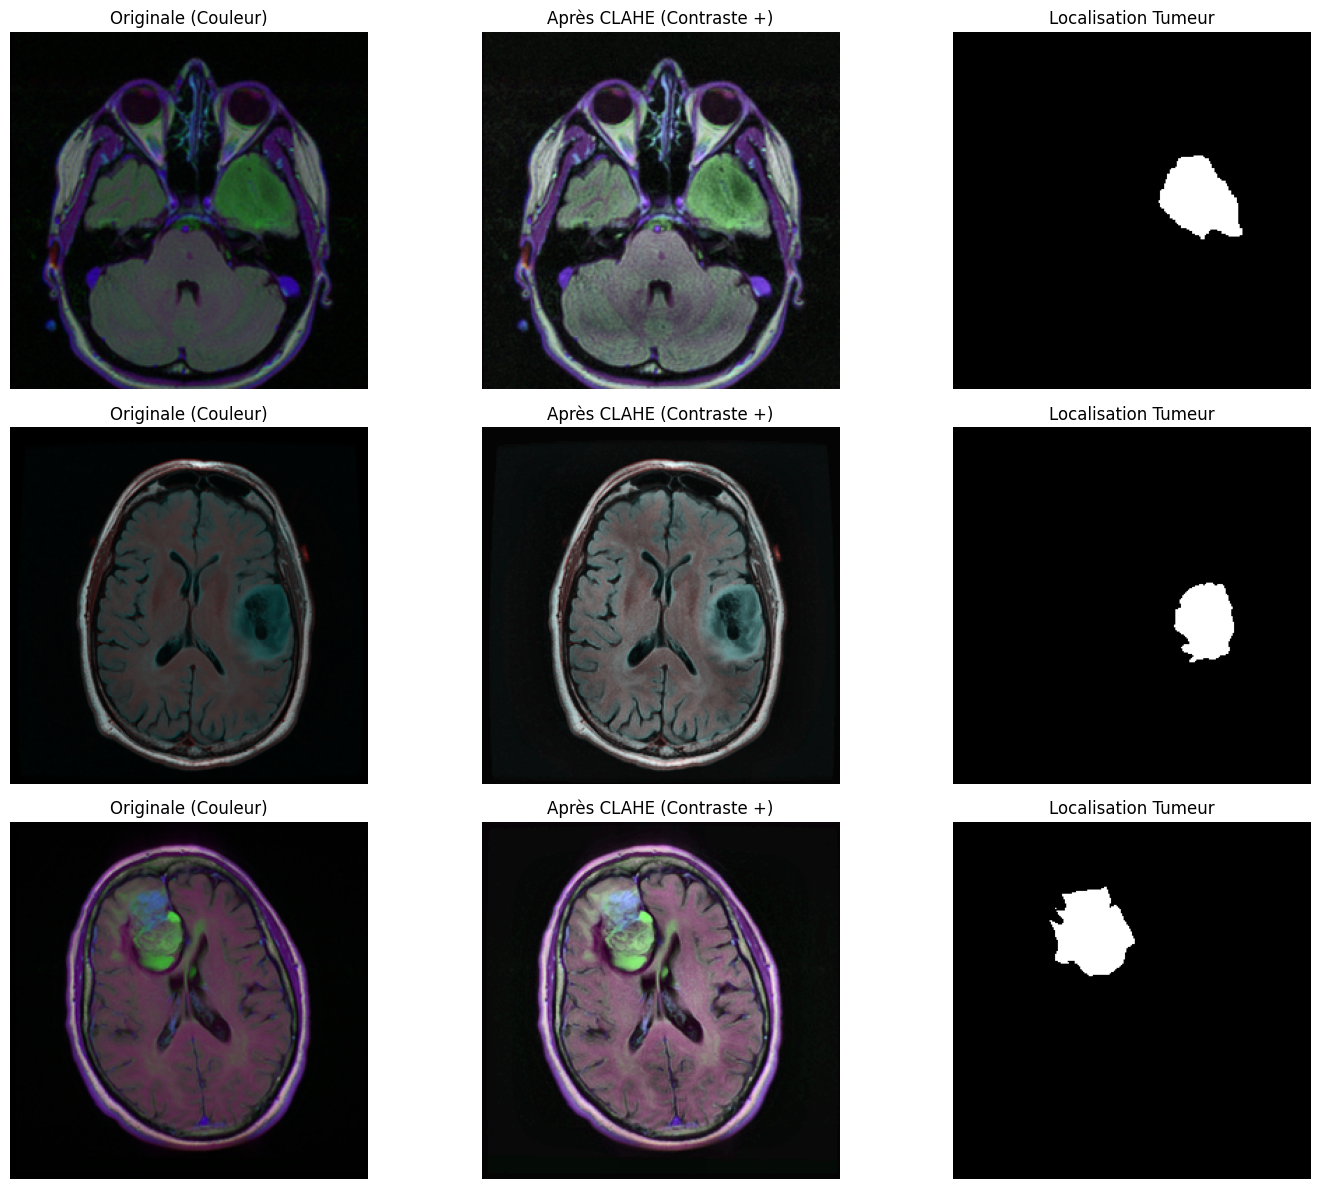

In [15]:
def apply_clahe_color(img):
    """
    Applique CLAHE en préservant les couleurs via l'espace LAB.
    """
    # 1. On convertit l'image BGR vers LAB
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # 2. On sépare les canaux (L = Luminosité, A et B = Couleurs)
    l, a, b = cv2.split(lab)

    # 3. On applique le CLAHE uniquement sur la Luminosité (L)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)

    # 4. On recolle les morceaux (Le L boosté + les A et B d'origine)
    lab_enhanced = cv2.merge((l2, a, b))

    # 5. On reconvertit en BGR pour l'affichage/utilisation
    enhanced_img = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    return enhanced_img

def visualize_contrast_enhancement(df, n_samples=3):
    plt.figure(figsize=(15, n_samples * 4))

    # Choix aléatoire d'images AVEC tumeur
    tumor_df = df[df['has_tumor'] == 1]
    indices = random.sample(range(len(tumor_df)), n_samples)

    for i, idx in enumerate(indices):
        img_path = tumor_df.iloc[idx]['image_path']
        mask_path = tumor_df.iloc[idx]['mask_path']

        # Lecture
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Application du CLAHE (Version couleur LAB)
        enhanced = apply_clahe_color(img)

        # --- AFFICHAGE ---

        # 1. Image Originale (EN COULEUR)
        plt.subplot(n_samples, 3, i*3 + 1)
        # Conversion BGR -> RGB pour que Matplotlib affiche les bonnes couleurs
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title("Originale (Couleur)")
        plt.axis('off')

        # 2. Image Améliorée (EN COULEUR)
        plt.subplot(n_samples, 3, i*3 + 2)
        # Conversion BGR -> RGB aussi pour l'image améliorée
        enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
        plt.imshow(enhanced_rgb)
        plt.title("Après CLAHE (Contraste +)")
        plt.axis('off')

        # 3. Masque
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Localisation Tumeur")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# --- Lancement du test ---
# On suppose que 'df_final' (ton dataframe équilibré) est toujours en mémoire
# Si tu l'as perdu, relance d'abord la création du dataframe
visualize_contrast_enhancement(df_final, n_samples=3)

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

class ColorContrastDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size=256, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))

        # Initialisation du CLAHE
        # On l'appliquera uniquement sur la luminosité (L)
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # ATTENTION : Ici on remet 3 canaux pour la couleur
        X = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)

        for i, idx in enumerate(indexes):
            img_path = self.df.iloc[idx]['image_path']
            mask_path = self.df.iloc[idx]['mask_path']

            # --- 1. CHARGEMENT & TRAITEMENT COULEUR (LAB) ---
            # Lecture standard en couleur (BGR par défaut dans OpenCV)
            img = cv2.imread(img_path)

            if img is not None:
                # A. Conversion BGR -> LAB
                lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

                # B. Séparation des canaux
                l, a, b = cv2.split(lab)

                # C. Application du CLAHE sur la Luminosité (L)
                l2 = self.clahe.apply(l)

                # D. Fusion et retour en BGR
                lab = cv2.merge((l2, a, b))
                img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

                # E. Standardisation
                img = cv2.resize(img, (self.img_size, self.img_size))
                img = img / 255.0  # Normalisation 0-1
                # Pas besoin d'expand_dims ici car l'image a déjà 3 canaux
                X[i] = img

            # --- 2. TRAITEMENT MASQUE ---
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = mask / 255.0
                mask = (mask > 0.5).astype(np.float32) # Binarisation stricte
                mask = np.expand_dims(mask, axis=-1)
                y[i] = mask

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

print("✅ Classe ColorContrastDataGenerator définie !")

# Instanciation des 3 générateurs (Train, Val ET Test)
train_gen_color = ColorContrastDataGenerator(train_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen_color = ColorContrastDataGenerator(val_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
test_gen_color = ColorContrastDataGenerator(test_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False)

print("✅ Les 3 générateurs (y compris Test) sont prêts en mode Couleur+CLAHE.")

✅ Classe ColorContrastDataGenerator définie !
✅ Les 3 générateurs (y compris Test) sont prêts en mode Couleur+CLAHE.


## Baseline Model

### Plot History Function

In [18]:
def plot_history(history, title="Baseline Model Performance"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Graphique de la LOSS (Erreur)
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss (Plus bas est mieux)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Dice Loss')
    ax1.legend()
    ax1.grid(True)

    # Graphique du DICE SCORE (Précision)
    ax2.plot(history.history['dice_coef'], label='Train Dice')
    ax2.plot(history.history['val_dice_coef'], label='Validation Dice')
    ax2.set_title(f'{title} - Dice Score (Plus haut est mieux)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Coefficient')
    ax2.legend()
    ax2.grid(True)

    plt.show()

### Predict Function

In [19]:
def predict_and_plot(model, df, n_samples=3):
    """
    Prend le modèle, le dataframe de test, et affiche n prédictions.
    """
    plt.figure(figsize=(15, n_samples * 4))

    # On choisit des indices au hasard dans le dataset de TEST
    # (Important : on ne teste pas sur ce qu'il a déjà appris !)
    indices = random.sample(range(len(df)), n_samples)

    for i, idx in enumerate(indices):
        # 1. Récupération des chemins
        img_path = df.iloc[idx]['image_path']
        mask_path = df.iloc[idx]['mask_path']

        # 2. Préparation de l'Image (Input)
        # Lecture + Resize + Normalisation
        img_raw = cv2.imread(img_path)
        img_input = cv2.resize(img_raw, (256, 256))
        img_input = img_input / 255.0 # Normalisation 0-1

        # Le modèle attend un batch (1, 256, 256, 3), pas juste (256, 256, 3)
        img_batch = np.expand_dims(img_input, axis=0)

        # 3. PRÉDICTION (.predict se fait ici !)
        pred_mask = model.predict(img_batch, verbose=0)

        # 4. Post-traitement
        # La sortie est une probabilité (ex: 0.8). On coupe à 0.5 pour avoir 0 ou 1.
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        # On retire la dimension du batch pour l'affichage (256, 256)
        pred_mask = np.squeeze(pred_mask)

        # Lecture du Vrai Masque pour comparer
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        true_mask = cv2.resize(true_mask, (256, 256))

        # --- AFFICHAGE ---
        # Colonne 1 : Image Originale
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
        plt.title(f"Radio Originale (Patient {idx})")
        plt.axis('off')

        # Colonne 2 : Vrai Masque (Ce qu'on attendait)
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Vérité Terrain (Cible)")
        plt.axis('off')

        # Colonne 3 : Prédiction (Ce que l'IA a vu)
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prédiction IA")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [21]:
# --- 1. DÉFINITION DES MÉTRIQUES (DICE) ---

def dice_coef(y_true, y_pred):
    # On aplatit les images pour comparer pixel par pixel
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # Formule du Dice : (2 * Intersection) / (Total pixels prédits + Total pixels réels)
    # Le smooth=1 évite la division par zéro
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [22]:
def baseline_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    model = Sequential()

    # Entrée
    model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))

    # --- ENCODEUR (Compression) ---
    # On réduit simplement la taille pour capter le contexte
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2))) # -> 128x128

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2))) # -> 64x64

    # --- BOTTLENECK ---
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    # --- DÉCODEUR (Reconstruction) ---
    # On regonfle sans aide (pas de skip connections)
    model.add(UpSampling2D((2, 2))) # -> 128x128
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(UpSampling2D((2, 2))) # -> 256x256
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    # --- SORTIE ---
    model.add(Conv2D(1, (1, 1), activation='sigmoid')) # Probabilité 0-1

    # Compilation (Mêmes métriques pour comparaison loyale)
    model.compile(optimizer='adam',
                  loss=dice_coef_loss,  # On garde la même loss custom
                  metrics=['accuracy', dice_coef])

    return model

# Instanciation de la Baseline
model_baseline = baseline_model(IMG_SIZE, IMG_SIZE, 3)
model_baseline.summary()

2025-12-03 16:38:10.523296: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-12-03 16:38:10.526082: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-03 16:38:10.527010: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-03 16:38:10.527658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 16:38:10.528094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 up_sampling2d (UpSampling2  (None, 128, 128, 128)     0

In [23]:
# --- 1. CONFIGURATION DES OUTILS DE CONTRÔLE ---
callbacks = [
    # Arrête l'entraînement si la "val_loss" ne descend plus après 5 époques
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

# --- 2. LANCEMENT DE L'ENTRAÎNEMENT ---
print("🏁 Début de l'entraînement du Baseline Model...")

history_baseline = model_baseline.fit(
    train_gen_color,
    validation_data=val_gen_color,
    epochs=30,  # On met 30, mais le EarlyStopping arrêtera sûrement avant
    callbacks=callbacks,
    verbose=1
)

🏁 Début de l'entraînement du Baseline Model...
Epoch 1/30


2025-12-03 16:38:25.499889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 77s 1s/step - loss: 0.7358 - accuracy: 0.7801 - dice_coef: 0.2642 - val_loss: 0.5036 - val_accuracy: 0.9902 - val_dice_coef: 0.4964
Epoch 2/30
61/61 [==============================] - 91s 1s/step - loss: 0.5046 - accuracy: 0.9850 - dice_coef: 0.4954 - val_loss: 0.4184 - val_accuracy: 0.9900 - val_dice_coef: 0.5816
Epoch 3/30
61/61 [==============================] - 79s 1s/step - loss: 0.4948 - accuracy: 0.9841 - dice_coef: 0.5052 - val_loss: 0.4828 - val_accuracy: 0.9830 - val_dice_coef: 0.5172
Epoch 4/30
61/61 [==============================] - 80s 1s/step - loss: 0.4825 - accuracy: 0.9849 - dice_coef: 0.5175 - val_loss: 0.4220 - val_accuracy: 0.9905 - val_dice_coef: 0.5780
Epoch 5/30
61/61 [==============================] - 138s 2s/step - loss: 0.4701 - accuracy: 0.9854 - dice_coef: 0.5299 - val_loss: 0.4644 - val_accuracy: 0.9837 - val_dice_coef: 0.5356
Epoch 6/30
61/61 [==============================] - 94s 2s/step - loss: 0.4696 - accuracy:

KeyboardInterrupt: 

In [ ]:
plot_history(history_baseline, title="Baseline Model Performance")

In [ ]:
model_mini_unet = mini_unet_model(IMG_SIZE, IMG_SIZE, 3)
print("✅ Modèle Mini U-Net reconstruit avec de nouveaux poids aléatoires.")

In [ ]:
# --- 2. Lancement de l'Entraînement ---
print("🏁 Début du nouvel entraînement du MINI U-NET...")
print(f"Objectif à battre (Baseline) : Dice Score > 0.62")

# Nous réutilisons les Callbacks simplifiés
mini_unet_callbacks_simple = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True),
]

history_mini_new = model_mini_unet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=mini_unet_callbacks_simple,
    verbose=1
)

# --- 3. Affichage des Courbes ---
plot_history(history_mini_new, title="Mini U-Net Performance (Nouveau Run)")

In [ ]:
# --- Lancer la démo sur le Baseline Model ---
# On utilise test_df pour être honnête (images jamais vues)
predict_and_plot(model_baseline, test_df, n_samples=5)

## Entraînement Mini-Unet

In [ ]:
def mini_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # --- NIVEAU 1 (Descente) ---
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # --- NIVEAU 2 (Descente) ---
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # --- BOTTLENECK (Le fond) ---
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # --- REMONTÉE NIVEAU 2 (Avec Pont !) ---
    u4 = UpSampling2D((2, 2))(c3)
    # ICI C'EST LA CLÉ : On recolle les infos de c2 (Niveau 2 original)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    # --- REMONTÉE NIVEAU 1 (Avec Pont !) ---
    u5 = UpSampling2D((2, 2))(c4)
    # ICI ON RECOLLE c1 (Niveau 1 original - Haute résolution)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    # --- SORTIE ---
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])

    # On compile avec les mêmes métriques pour comparer ce qui est comparable
    model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy', dice_coef])

    return model

# Instanciation et Résumé
model_mini_unet = mini_unet_model(IMG_SIZE, IMG_SIZE, 3)
model_mini_unet.summary()

In [ ]:
# --- 1. Définition des Callbacks Simplifiés ---
# Nous conservons uniquement l'Early Stopping (arrêt précoce) pour optimiser le temps
mini_unet_callbacks_simple = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)

# --- 2. Lancement de l'Entraînement ---
print("🏁 Début de l'entraînement du MINI U-NET (Version Test)...")
print(f"Objectif à battre (Baseline) : Dice Score > 0.65")

# Assure-toi que cette ligne est exécutée une seule fois dans le notebook pour instancier le modèle :
model_mini_unet = mini_unet_model(IMG_SIZE, IMG_SIZE, 3)

history_mini = model_mini_unet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Le nombre maximum d'époques, l'Early Stopping l'arrêtera avant si besoin
    callbacks=mini_unet_callbacks_simple,
    verbose=1
)

In [ ]:
# --- 3. Affichage des Courbes ---
# Cette fonction utilise matplotlib pour afficher l'historique d'apprentissage
plot_history(history_mini, title="Mini U-Net Performance (Simple)")

In [ ]:
predict_and_plot(model_mini_unet, test_df, n_samples=5)